# Machine Learning USA - Feature Selection

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_df = pd.read_csv('data_complete_new.csv')

In [3]:
data_df.shape

(80571, 146)

### Separação das variáveis de entrada e suas classes

In [4]:
X = data_df.copy()

del X['INJ_SEV']

y = data_df['INJ_SEV']

print("Dimensões da base X:", X.shape)
print("Dimensões da base y:", y.shape)

Dimensões da base X: (80571, 145)
Dimensões da base y: (80571,)


### Separação da base de treinamento e teste

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=True)

In [6]:
print("Dimensões da base X_train:", X_train.shape)
print("Dimensões da base X_test:", X_test.shape)
print("Dimensões da base y_train:", y_train.shape)
print("Dimensões da base y_test:", y_test.shape)

Dimensões da base X_train: (64456, 145)
Dimensões da base X_test: (16115, 145)
Dimensões da base y_train: (64456,)
Dimensões da base y_test: (16115,)


### Analise inicial

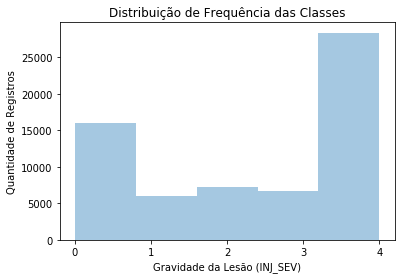

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(y_train, bins = 5, kde = False)

plt.title("Distribuição de Frequência das Classes")
plt.xlabel("Gravidade da Lesão (INJ_SEV)")
plt.ylabel("Quantidade de Registros")
plt.xticks(range(5))
plt.show()

### Balanceando o dataset

In [9]:
from imblearn.combine import SMOTETomek

smk = SMOTETomek(random_state=42)
X_res, y_res = smk.fit_sample(X_train, y_train)

In [10]:
y_res.shape

print("Dimensões da base X_res:", X_res.shape)
print("Dimensões da base y_res:", y_res.shape)

Dimensões da base X_res: (132785, 145)
Dimensões da base y_res: (132785,)


### Analise após balanceamento

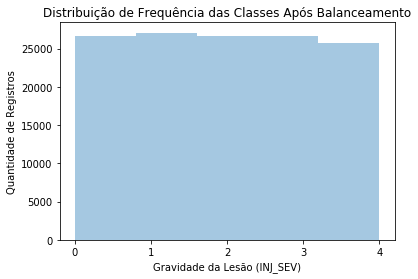

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(y_res, bins = 5, kde = False)

plt.title("Distribuição de Frequência das Classes Após Balanceamento")
plt.xlabel("Gravidade da Lesão (INJ_SEV)")
plt.ylabel("Quantidade de Registros")
plt.xticks(range(5))
plt.show()

## Randomized Search-CV

Obtendo os melhores parâmetros para criação de um modelo usando Random Forest

In [148]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
import datetime

import warnings
warnings.filterwarnings('ignore')

inicio = datetime.datetime.now()


RF = RandomForestClassifier(n_jobs = -1, random_state=0)

n_estimators = [50, 100, 200, 300, 600, 1000]
criterion = ['gini', 'entropy']
max_depth = [10, 30, 50, 100, 200]

distributions = dict(n_estimators=n_estimators, criterion=criterion,
                           max_depth=max_depth)

clf = RandomizedSearchCV(RF, distributions, scoring='accuracy')

search = clf.fit(X_res, y_res)
print(search.best_params_, search.best_score_)

    
print("Tempo total de execução: ", (datetime.datetime.now()) - inicio)

{'n_estimators': 200, 'max_depth': 50, 'criterion': 'gini'} 0.9048838347704937
Tempo total de execução:  2:00:00.759353


### Classificação - Base Original

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import datetime

inicio = datetime.datetime.now()

RF = RandomForestClassifier(n_estimators= 200, max_depth= 50, criterion= 'gini')

RF.fit(X_res, y_res)

fim = datetime.datetime.now()

y_pred_RF = RF.predict(X_test)

tempo_execucao = fim - inicio

print("Tempo de execução:", tempo_execucao)

print("Acurácia: ", accuracy_score(y_test, y_pred_RF))
print("Métricas: ", precision_recall_fscore_support(y_test, y_pred_RF, average='macro'))

Tempo de execução: 0:03:54.462018
Acurácia:  0.7866583928017375
Métricas:  (0.6832910653508175, 0.6665789226383984, 0.6718788877622652, None)


In [15]:
for i in range(5):
    print("Métricas classe", i , ":", precision_recall_fscore_support(y_test, y_pred_RF, average='micro', labels=[i]))

Métricas classe 0 : (0.8702290076335878, 0.9433299899699097, 0.9053062206713992, None)
Métricas classe 1 : (0.5895117540687161, 0.43007915567282323, 0.4973302822273074, None)
Métricas classe 2 : (0.5236102809324567, 0.48105436573311366, 0.5014310246136233, None)
Métricas classe 3 : (0.546426561620709, 0.5748963883955003, 0.5603000577034044, None)
Métricas classe 4 : (0.886677722498618, 0.903534713420645, 0.8950268535955919, None)


In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_RF)

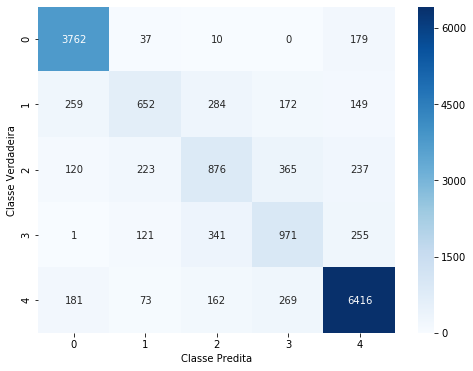

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='', cmap='Blues')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

In [18]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(y_test, y_pred_RF, labels=[0, 1, 2, 3, 4])

Classe  0


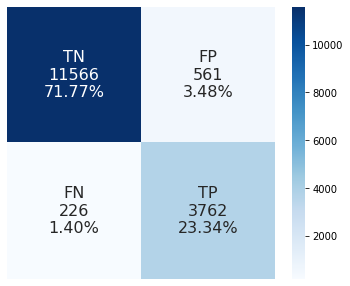





Classe  1


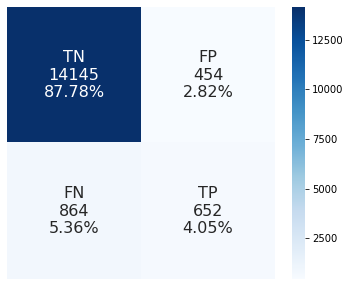





Classe  2


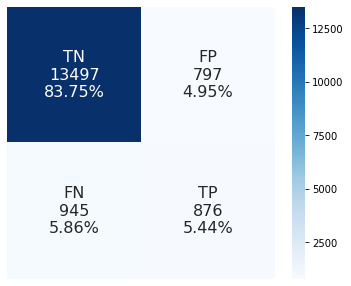





Classe  3


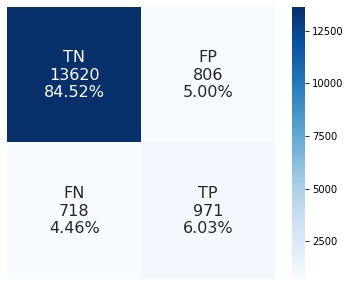





Classe  4


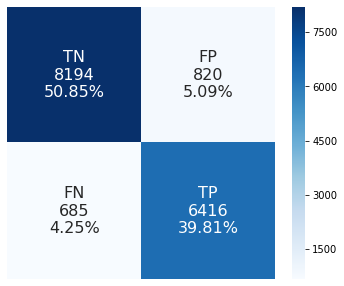

In [24]:
for i in range(5):
    plt.figure(figsize=(6,5))
    
    print("Classe ", i)

    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                    mcm[i].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         mcm[i].flatten()/np.sum(mcm[0])]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(mcm[i], annot=labels, annot_kws={"size": 16}, fmt='', cmap='Blues', xticklabels=False, yticklabels=False)
    plt.show()
    
    print('\n')
    print('\n')

### Embedded - Feature Importances

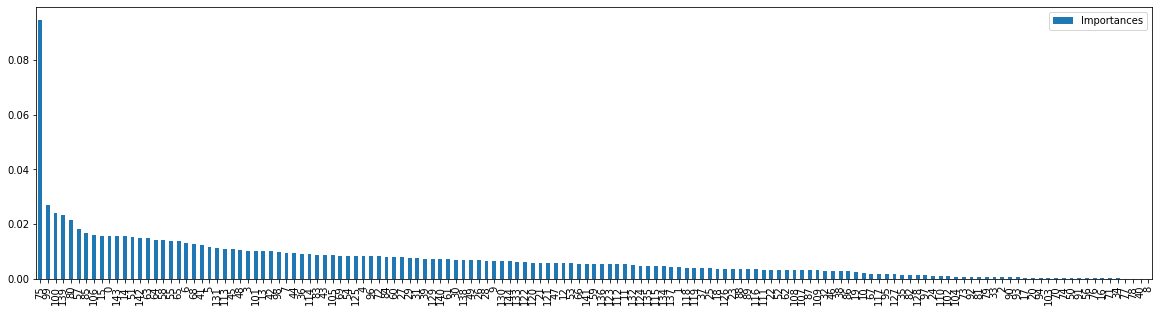

In [25]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

model = RandomForestClassifier(n_estimators= 200, max_depth= 50, criterion= 'gini')

model.fit(X_res, y_res)

importances = model.feature_importances_

selected_features = pd.DataFrame({"Features": X_train.columns, "Importances":importances})
selected_features.set_index('Importances')

selected_features = selected_features.sort_values('Importances', ascending = False)

plt.rcParams['figure.figsize']=(20,5)

selected_features.plot.bar()

In [31]:
selected_features = selected_features.query("Importances >= 0.01").sort_values('Importances', ascending = False)

selected_features

,Features,Importances
75,HOSPITAL,0.094618
99,DEFORMED,0.026748
100,TOWED,0.024139
139,P_CRASH2,0.023110
80,NUMOCCS,0.021373
57,AIR_BAG,0.018260
85,MODEL,0.016807
106,DR_ZIP,0.016090
15,LONGITUD,0.015759
0,ST_CASE,0.015714


In [63]:
X_train_selected = X_res.iloc[:,selected_features.index]

X_test_selected = X_test.iloc[:,selected_features.index]

In [64]:
X_test_selected

,HOSPITAL,DEFORMED,TOWED,P_CRASH2,NUMOCCS,AIR_BAG,MODEL,DR_ZIP,LONGITUD,ST_CASE,...,DSTATUS,COUNTY,PERMVIT,VSPD_LIM,DR_HGT,MINUTE,HARM_EV,PEDS,M_HARM,MILEPT
48547,0,6.0,2.0,6.0,3.0,99,37.0,28551.0,-77.848308,371259,...,0,191,3,45.0,71.0,16,42,0,2.0,99999
46715,5,6.0,2.0,12.0,1.0,0,18.0,28602.0,-81.368972,370455,...,0,35,1,98.0,71.0,22,30,0,30.0,0
56877,0,6.0,2.0,62.0,1.0,1,18.0,29588.0,-79.078036,450469,...,2,51,2,50.0,65.0,10,12,0,12.0,0
53279,0,9.0,8.0,80.0,1.0,20,26.0,97027.0,-122.633892,410322,...,0,5,1,40.0,66.0,16,8,1,8.0,72
21690,5,6.0,2.0,10.0,2.0,1,443.0,30046.0,-83.998161,130696,...,0,135,3,45.0,68.0,52,12,0,12.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77723,1,10.0,10.0,100.0,100.0,97,1000.0,100000.0,-119.748425,320138,...,2,5,4,100.0,1000.0,36,8,1,100.0,99998
20789,5,6.0,2.0,66.0,2.0,1,22.0,30633.0,-83.441731,130309,...,0,157,4,55.0,62.0,12,12,0,12.0,145
34398,5,6.0,2.0,53.0,1.0,20,403.0,99997.0,-82.840761,260267,...,0,99,2,55.0,998.0,18,12,1,12.0,127
11664,5,6.0,2.0,66.0,1.0,0,709.0,95376.0,-121.487669,63055,...,0,77,3,55.0,74.0,25,12,0,12.0,0


### Classificação da Base Reduzida

### Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support

inicio = datetime.datetime.now()

RF_reduzida = RandomForestClassifier(n_estimators= 200, max_depth= 50, criterion= 'gini')

RF_reduzida.fit(X_train_selected, y_res)

fim = datetime.datetime.now()

y_pred_RF_reduzida = RF_reduzida.predict(X_test_selected)

tempo_execucao = fim - inicio

print("Tempo de execução:", tempo_execucao)

print("Acurácia: ", accuracy_score(y_test, y_pred_RF_reduzida))
print("Métricas: ", precision_recall_fscore_support(y_test, y_pred_RF_reduzida, average='macro'))

Tempo de execução: 0:02:29.401199
Acurácia:  0.7754886751473782
Métricas:  (0.6695320293718042, 0.6583916129490246, 0.6615240142483325, None)


In [67]:
for i in range(5):
    print("Métricas classe", i , ":", precision_recall_fscore_support(y_test, y_pred_RF_reduzida, average='micro', labels=[i]))

Métricas classe 0 : (0.8614958448753463, 0.9358074222668004, 0.8971153846153846, None)
Métricas classe 1 : (0.57243195785777, 0.43007915567282323, 0.4911487758945386, None)
Métricas classe 2 : (0.5051136363636364, 0.48819330038440417, 0.4965093549287909, None)
Métricas classe 3 : (0.5224215246636771, 0.551805802249852, 0.53671177656205, None)
Métricas classe 4 : (0.8861971830985915, 0.8860723841712435, 0.8861347792408986, None)


In [71]:
from sklearn.metrics import confusion_matrix

cm_rf_reduzida = confusion_matrix(y_test, y_pred_RF_reduzida)

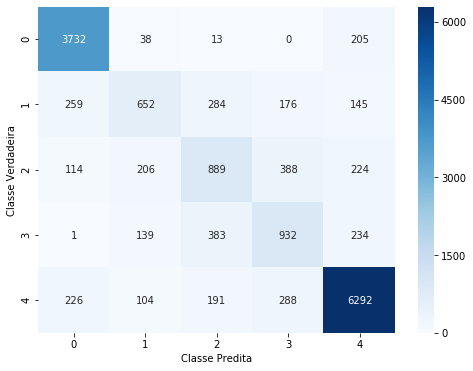

In [74]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf_reduzida, annot=True, fmt='', cmap='Blues')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

In [75]:
from sklearn.metrics import multilabel_confusion_matrix

mcm_rf_reduzida = multilabel_confusion_matrix(y_test, y_pred_RF_reduzida, labels=[0, 1, 2, 3, 4])

Classe  0


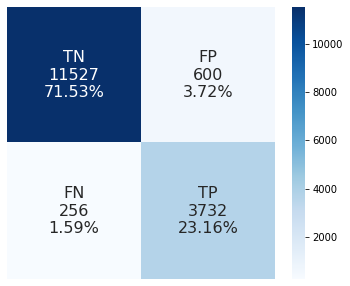





Classe  1


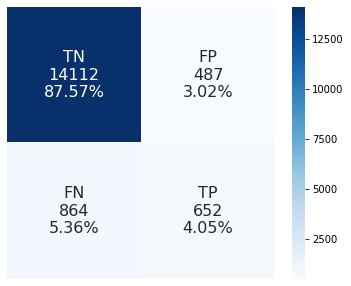





Classe  2


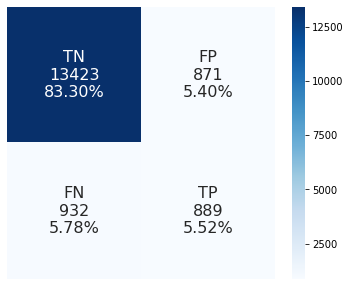





Classe  3


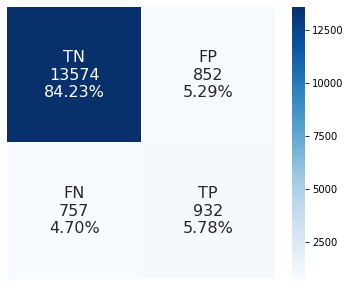





Classe  4


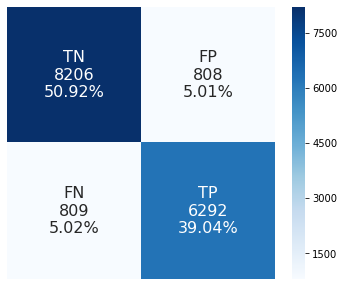

In [76]:
for i in range(5):
    plt.figure(figsize=(6,5))
    
    print("Classe ", i)

    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                    mcm_rf_reduzida[i].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         mcm_rf_reduzida[i].flatten()/np.sum(mcm_rf_reduzida[0])]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(mcm_rf_reduzida[i], annot=labels, annot_kws={"size":16}, fmt='', cmap='Blues', xticklabels=False, yticklabels=False)
    plt.show()
    
    print('\n')
    print('\n')

### AdaBoost

In [84]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import datetime

inicio = datetime.datetime.now()

estimator = DecisionTreeClassifier(random_state=0, max_depth= 50, criterion= 'gini')

AB_accuracy = []
AB_index = []

for k in range(10):
    AB = AdaBoostClassifier(base_estimator = estimator, n_estimators=(k+1)*50, random_state=0)
    AB.fit(X_train_selected, y_res)

    y_pred_AB = AB.predict(X_test_selected)
    
    AB_accuracy.append(accuracy_score(y_test, y_pred_AB))
    AB_index.append((k+1)*100)
    
fim = datetime.datetime.now()
tempo_execucao = fim - inicio

print("Tempo de execução:", tempo_execucao)

print("Acurácia: ", accuracy_score(y_test, y_pred_AB))
print("Métricas: ", precision_recall_fscore_support(y_test, y_pred_AB, average='macro'))


Tempo de execução: 3:07:07.745998
Acurácia:  0.7632640397145517
Métricas:  (0.6577253026045801, 0.6468671015347734, 0.6499339184977047, None)


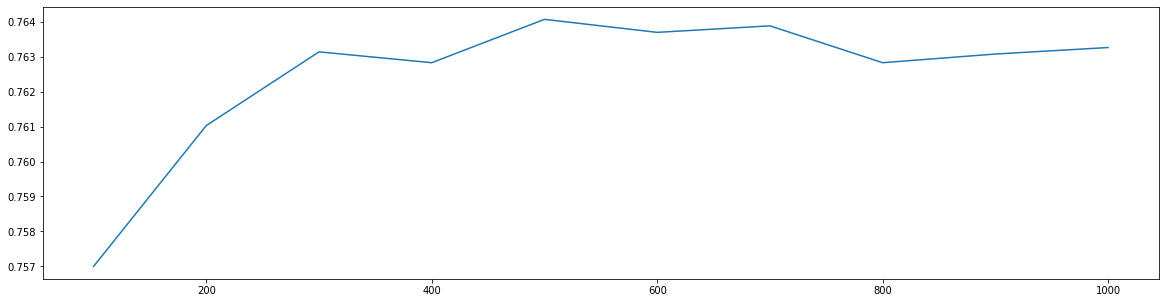

In [85]:
import matplotlib.pyplot as plt

plt.plot(AB_index, AB_accuracy)

In [88]:
from sklearn.ensemble import AdaBoostClassifier

inicio = datetime.datetime.now()

estimator = DecisionTreeClassifier(random_state=0, max_depth= 50, criterion= 'gini')

AB_reduzida = AdaBoostClassifier(base_estimator = estimator, n_estimators=500, random_state=0)
AB_reduzida.fit(X_train_selected, y_res)

fim = datetime.datetime.now()

y_pred_AB_reduzida = AB_reduzida.predict(X_test_selected)

tempo_execucao = fim - inicio

print("Tempo de execução:", tempo_execucao)
    
print("Acurácia: ", accuracy_score(y_test, y_pred_AB_reduzida))
print("Métricas: ", precision_recall_fscore_support(y_test, y_pred_AB_reduzida, average='macro'))

Tempo de execução: 0:33:37.101921
Acurácia:  0.7632640397145517
Métricas:  (0.6577253026045801, 0.6468671015347734, 0.6499339184977047, None)


In [89]:
for i in range(5):
    print("Métricas classe", i , ":", precision_recall_fscore_support(y_test, y_pred_AB_reduzida, average='micro', labels=[i]))

Métricas classe 0 : (0.8648148148148148, 0.9368104312938816, 0.8993740972556572, None)
Métricas classe 1 : (0.5588235294117647, 0.4261213720316623, 0.4835329341317365, None)
Métricas classe 2 : (0.4919881305637982, 0.4552443712246019, 0.4729035938391329, None)
Métricas classe 3 : (0.5093509350935094, 0.5482534043812907, 0.5280866837753065, None)
Métricas classe 4 : (0.8636491031390134, 0.8679059287424307, 0.8657722834866897, None)


In [90]:
from sklearn.metrics import confusion_matrix

cm_ab_reduzida = confusion_matrix(y_test, y_pred_AB_reduzida)

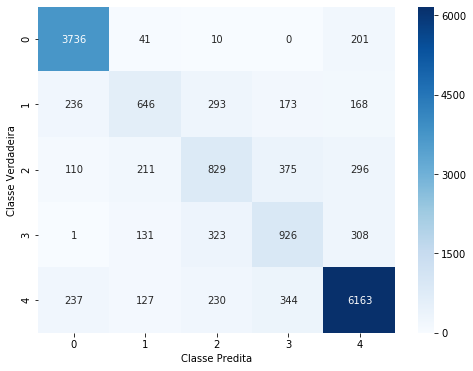

In [91]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_ab_reduzida, annot=True, fmt='', cmap='Blues')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

In [92]:
from sklearn.metrics import multilabel_confusion_matrix

mcm_ab_reduzida = multilabel_confusion_matrix(y_test, y_pred_AB_reduzida, labels=[0, 1, 2, 3, 4])

Classe  0


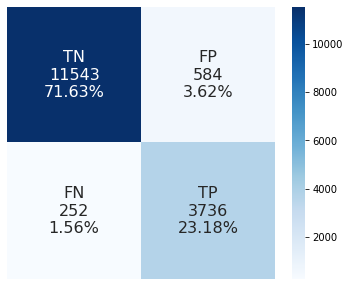





Classe  1


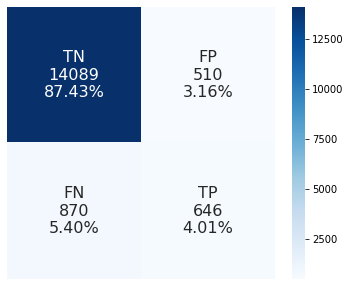





Classe  2


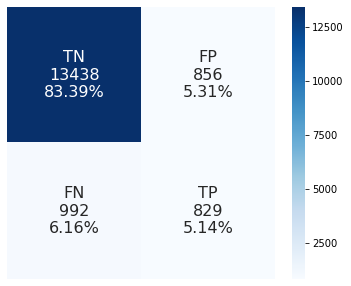





Classe  3


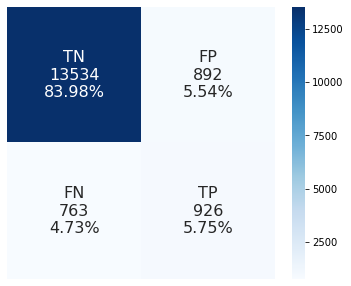





Classe  4


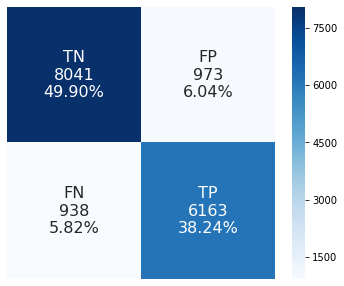

In [96]:
for i in range(5):
    plt.figure(figsize=(6,5))
    
    print("Classe ", i)

    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                    mcm_ab_reduzida[i].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         mcm_ab_reduzida[i].flatten()/np.sum(mcm_ab_reduzida[0])]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(mcm_ab_reduzida[i], annot=labels, annot_kws={"size":16}, fmt='', cmap='Blues', xticklabels = False, yticklabels = False)
    plt.show()
    
    print('\n')
    print('\n')

### Árvore de Decisão

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support
import datetime

inicio = datetime.datetime.now()

dt = DecisionTreeClassifier(random_state=0, max_depth= 50, criterion= 'gini')

dt.fit(X_train_selected, y_res)

fim = datetime.datetime.now()

y_pred_DT_reduzida = dt.predict(X_test_selected)

tempo_execucao = fim - inicio

print("Tempo de execução:", tempo_execucao)
    
print("Acurácia: ", accuracy_score(y_test, y_pred_DT_reduzida))
print("Métricas: ", precision_recall_fscore_support(y_test, y_pred_DT_reduzida, average='macro'))

Tempo de execução: 0:00:05.101062
Acurácia:  0.7056779398076326
Métricas:  (0.5857804429158375, 0.5961080059048998, 0.5900265581260589, None)


In [16]:
for i in range(5):
    print("Métricas classe", i , ":", precision_recall_fscore_support(y_test, y_pred_DT_reduzida, average='micro', labels=[i]))

Métricas classe 0 : (0.8528453246427676, 0.8530591775325977, 0.8529522376833395, None)
Métricas classe 1 : (0.35280898876404493, 0.41424802110817943, 0.3810679611650485, None)
Métricas classe 2 : (0.4051638530287984, 0.44810543657331137, 0.42555410691003914, None)
Métricas classe 3 : (0.4482758620689655, 0.4541148608644168, 0.45117647058823535, None)
Métricas classe 4 : (0.8698081860746111, 0.8110125334459936, 0.8393820142836321, None)


In [17]:
from sklearn.metrics import confusion_matrix

cm_dt_reduzida = confusion_matrix(y_test, y_pred_DT_reduzida)

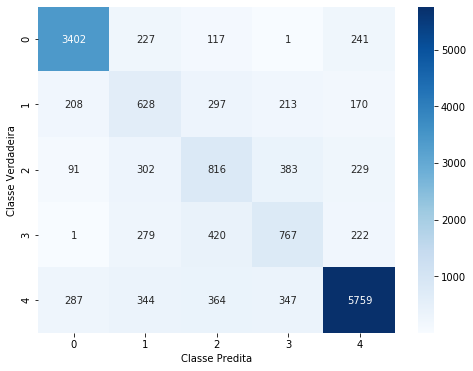

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_dt_reduzida, annot=True, fmt='', cmap='Blues')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.show()

In [19]:
from sklearn.metrics import multilabel_confusion_matrix

mcm_dt_reduzida = multilabel_confusion_matrix(y_test, y_pred_DT_reduzida, labels=[0, 1, 2, 3, 4])

Classe  0


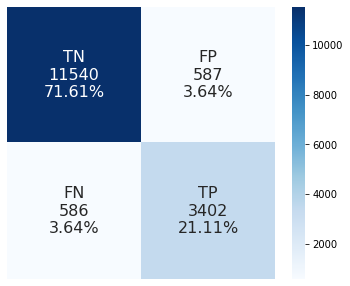





Classe  1


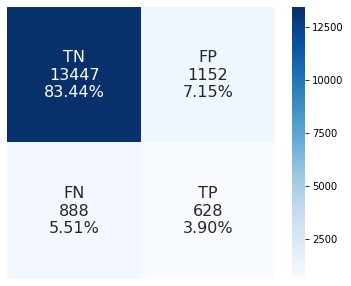





Classe  2


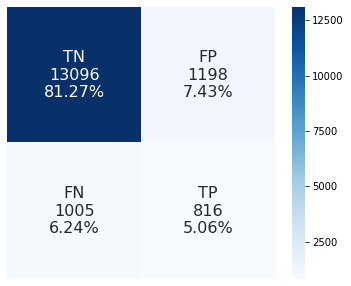





Classe  3


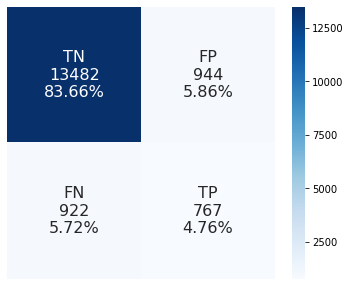





Classe  4


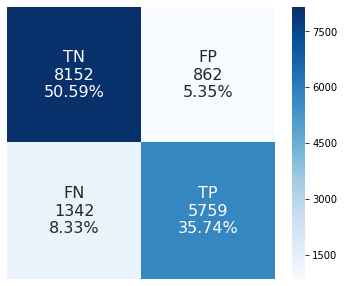

In [24]:
for i in range(5):
    plt.figure(figsize=(6,5))
    
    print("Classe ", i)

    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                    mcm_dt_reduzida[i].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         mcm_dt_reduzida[i].flatten()/np.sum(mcm_dt_reduzida[0])]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(mcm_dt_reduzida[i], annot=labels, annot_kws={"size":16}, fmt='', cmap='Blues', xticklabels = False, yticklabels = False)
    plt.show()
    
    print('\n')
    print('\n')